In [1]:
# Cell 1 - imports & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
import statsmodels.api as sm
import shap

# load
path = "C:/Users/UserAdmin/Desktop/5126final/model/preprocessed_data.csv"   # adjust if needed
df = pd.read_csv(path)
print("rows, cols:", df.shape)

# quick peek
df[[c for c in df.columns if c.startswith('Q274')][:1]].head()


rows, cols: (2012, 287)


,Q274: How many children do you have
0,1.0
1,0.0
2,0.0
3,1.0
4,3.0


In [2]:
# Cell 2 - create age and target, filter
CURRENT_YEAR = 2025
# target column (as found)
target_col = 'Q274: How many children do you have'
birth_year_col = 'Q261: Year of birth'  # exists in dataset preview
country_col = 'Q266: Country of birth: Respondent'  # numeric ISO code

# convert to numeric and handle bad/missing
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
df[birth_year_col] = pd.to_numeric(df[birth_year_col], errors='coerce')
df[country_col] = pd.to_numeric(df[country_col], errors='coerce')

# compute age
df['age'] = CURRENT_YEAR - df[birth_year_col]

# childbearing filter: 20-49 (common bracket) — adjust if needed
df_childbearing = df[(df['age'] >= 20) & (df['age'] <= 49)].copy()
print("Childbearing Rows (i.e. Those Age 20-49):", df_childbearing.shape[0])

# Singapore subset (ISO numeric 702)
df_sg = df_childbearing[df_childbearing[country_col] == 702].copy()
print("Singapore rows (i.e. Singaporeans Age 20-49):", df_sg.shape[0])

# global (all countries in same age bracket)
df_global = df_childbearing.copy()


Childbearing Rows (i.e. Those Age 20-49): 875
Singapore rows (i.e. Singaporeans Age 20-49): 699


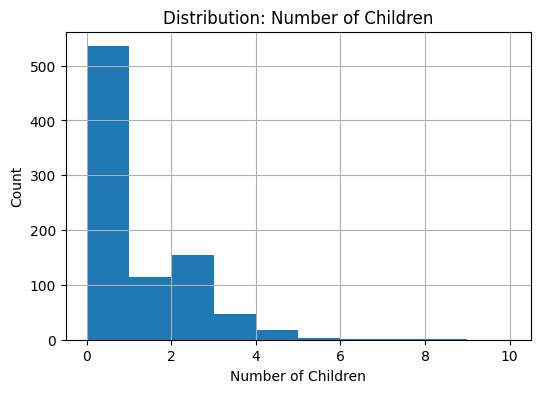

In [3]:
# Cell 3 - EDA: target distribution and missingness
import matplotlib.pyplot as plt

# target distribution
plt.figure(figsize=(6,4))
df_childbearing[target_col].dropna().hist(bins=range(0,11))
plt.title('Distribution: Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.show()

# missingness overview for top columns check for columnns with least missing values
#miss = df_childbearing.isnull().mean().sort_values()
#miss.head(30)


In [4]:
# Candidate features: include all columns except the target (no heuristic filtering)
candidate_cols = [c for c in df.columns if c != target_col]
len(candidate_cols), candidate_cols[:40]


(287,
 ['N_REGION_ISO: Region ISO 3166-2',
  'Q1: Important in life: Family',
  'Q2: Important in life: Friends',
  'Q3: Important in life: Leisure time',
  'Q4: Important in life: Politics',
  'Q5: Important in life: Work',
  'Q6: Important in life: Religion',
  'Q7: Important child qualities: good manners',
  'Q8: Important child qualities: independence',
  'Q9: Important child qualities: hard work',
  'Q10: Important child qualities: feeling of responsibility',
  'Q11: Important child qualities: imagination',
  'Q12: Important child qualities: tolerance and respect for other people',
  'Q13: Important child qualities: thrift saving money and things',
  'Q14: Important child qualities: determination perseverance',
  'Q15: Important child qualities: religious faith',
  'Q16: Important child qualities: unselfishness',
  'Q17: Important child qualities: obedience',
  'Q18: Neighbors: Drug addicts',
  'Q19: Neighbors: People of a different race',
  'Q20: Neighbors: People who have AIDS',

In [5]:
# Cell 5A - Poisson using statsmodels (requires adding constant)
# Ensure required variables exist (features, X_sg_proc, y_sg). Fall back to sensible defaults.

# use candidate_cols (from earlier cell) if 'features' is not defined
if 'features' not in globals():
	features = candidate_cols  # candidate_cols defined in Cell 3

# Prepare X and y from the Singapore subset df_sg
X_sg = df_sg[features].copy()
y_sg = df_sg[target_col].copy()

# keep only rows with observed target
mask = y_sg.notna()
X_sg = X_sg.loc[mask]
y_sg = y_sg.loc[mask]

# simple preprocessing: impute numeric missings with column medians
X_sg_proc = X_sg.fillna(X_sg.median())

#Above for Data Cleaning

# add constant and fit Poisson GLM
X_sm = sm.add_constant(X_sg_proc)
#poisson_model = sm.GLM(y_sg.values, X_sm, family=sm.families.Poisson()).fit()
#print(poisson_model.summary())


In [6]:
#nb_model = sm.GLM(y_sg.values, X_sm, family=sm.families.NegativeBinomial()).fit()
#print(nb_model.summary())


In [7]:
# Cell 5B - RF regressor with cross-validation
rf = RandomForestRegressor(n_estimators=500, random_state=42)
scores = cross_val_score(rf, X_sg_proc, y_sg, cv=5, scoring='neg_mean_squared_error') #splitting comprised of 5 folds
print("CV RMSE:", np.sqrt(-scores).mean())
# train final
rf.fit(X_sg_proc, y_sg)


CV RMSE: 0.6207126340936397


,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
# Cell 5C - classification bucket
# Use the already-prepared y_sg (filtered) and X_sg_proc (processed) to build a classification target
y_class = pd.cut(y_sg, bins=[-1,0,1,100], labels=['0','1','2+'])

# RandomForestClassifier is already imported in an earlier cell; do not re-import
clf = RandomForestClassifier(n_estimators=500, random_state=42)
X_proc = X_sg_proc
clf.fit(X_proc, y_class)

print("Train acc:", clf.score(X_proc, y_class))


Train acc: 1.0


In [9]:
'''
# Cell 6 - SHAP: simplified ranked mean(|SHAP|) horizontal bar chart
# This cell preserves DataFrame column names, samples a small background for TreeExplainer,
# and plots mean absolute SHAP per feature as a horizontal bar chart (top-N).
# Ensure prerequisites: `features`, `X_sg`, `y_sg`, and `rf` should exist from earlier cells.

# ensure a preprocessor exists and is fitted (fit on X_sg if needed)
if 'preprocessor' not in globals():
    preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
# try a quick transform to detect if fitted; otherwise fit on X_sg
try:
    _ = preprocessor.transform(X_sg.iloc[:1])
except Exception:
    preprocessor.fit(X_sg.fillna(X_sg.median()))

# build a DataFrame of preprocessed features so column names are preserved
if 'X_sg_proc_df' in globals():
    X_shap_df = X_sg_proc_df.copy()
else:
    X_shap_input = X_sg[features].copy()
    X_shap_input = X_shap_input.fillna(X_shap_input.median())
    X_shap_proc = preprocessor.transform(X_shap_input)
    X_shap_df = pd.DataFrame(X_shap_proc, columns=features, index=X_shap_input.index)

# Ensure the RF model has feature names info; if not, clone & (re)fit on DataFrame slice
from sklearn.base import clone
rf_for_shap = rf
need_refit = False
if not hasattr(rf_for_shap, 'feature_names_in_'):
    need_refit = True
else:
    try:
        if list(rf_for_shap.feature_names_in_) != list(features):
            need_refit = True
    except Exception:
        need_refit = True
if need_refit:
    rf_for_shap = clone(rf)
    rf_for_shap.fit(X_shap_df, y_sg.loc[X_shap_df.index])

# create a small background sample for the explainer (keeps things fast)
bg_n = min(200, len(X_shap_df))
bg = X_shap_df.sample(n=bg_n, random_state=0)

# compute SHAP values using TreeExplainer where possible; fallback to generic Explainer
try:
    expl = shap.TreeExplainer(rf_for_shap, data=bg)
    shap_vals = expl.shap_values(X_shap_df)
except Exception:
    expl = shap.Explainer(rf_for_shap.predict, bg)
    # shap.Explainer returns an object w/ .values for most models
    out = expl(X_shap_df)
    try:
        shap_vals = out.values
    except Exception:
        # final fallback: compute numeric array from object
        shap_vals = np.array(out)

# shap_vals might be a list (multiclass) or ndarray. Convert to absolute and average appropriately
import numpy as np
if isinstance(shap_vals, list):
    # for multiclass, average absolute values across classes
    arr = np.mean([np.abs(s) for s in shap_vals], axis=0)
else:
    arr = np.abs(shap_vals)
mean_abs = np.mean(arr, axis=0)
imp = pd.Series(mean_abs, index=features).sort_values(ascending=True)

# Plot top-N features as horizontal bar chart
topn = 20
imp_top = imp.tail(topn)
plt.figure(figsize=(8, max(4, 0.3 * topn)))
imp_top.plot.barh(color='C1')
plt.xlabel('Mean |SHAP value|')
plt.title('Feature importance (mean |SHAP|) - Singapore RF')
plt.tight_layout()
plt.show()

# Print the top 10 features for quick reference
print('Top 10 features by mean |SHAP|:')
print(imp.sort_values(ascending=False).head(10))
'''

"\n# Cell 6 - SHAP: simplified ranked mean(|SHAP|) horizontal bar chart\n# This cell preserves DataFrame column names, samples a small background for TreeExplainer,\n# and plots mean absolute SHAP per feature as a horizontal bar chart (top-N).\n# Ensure prerequisites: `features`, `X_sg`, `y_sg`, and `rf` should exist from earlier cells.\n\n# ensure a preprocessor exists and is fitted (fit on X_sg if needed)\nif 'preprocessor' not in globals():\n    preprocessor = Pipeline(steps=[\n        ('imputer', SimpleImputer(strategy='median')),\n        ('scaler', StandardScaler())\n    ])\n# try a quick transform to detect if fitted; otherwise fit on X_sg\ntry:\n    _ = preprocessor.transform(X_sg.iloc[:1])\nexcept Exception:\n    preprocessor.fit(X_sg.fillna(X_sg.median()))\n\n# build a DataFrame of preprocessed features so column names are preserved\nif 'X_sg_proc_df' in globals():\n    X_shap_df = X_sg_proc_df.copy()\nelse:\n    X_shap_input = X_sg[features].copy()\n    X_shap_input = X_shap

In [10]:
# Cell 7 - replicate modelling on global sample; compare feature importance
# Prepare global dataset same way:
global_df = df_global.dropna(subset=[target_col]).copy()
global_df = global_df[(global_df['age'] >= 20) & (global_df['age'] <= 49)]

# You may need to subset to rows with valid features
X_global = global_df[features].copy()
y_global = global_df[target_col]

# Ensure a preprocessor exists (fit if missing). Use a simple numeric pipeline:
# SimpleImputer (median) + StandardScaler
if 'preprocessor' not in globals():
	preprocessor = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='median')),
		('scaler', StandardScaler())
	])
	# Prefer to fit on already-prepared Singapore data if available, otherwise fit on X_global
	if 'X_sg_proc' in globals():
		preprocessor.fit(X_sg_proc)
	else:
		preprocessor.fit(X_global.fillna(X_global.median()))

# Transform global features (pipeline will impute missing values)
X_global_proc = preprocessor.transform(X_global)

# Train RF on global
rf_global = RandomForestRegressor(n_estimators=200, random_state=42)
rf_global.fit(X_global_proc, y_global)

# Compute top importances for both models
importances_sg = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False).head(15)
importances_global = pd.Series(rf_global.feature_importances_, index=features).sort_values(ascending=False).head(15)
print("SG top features:\n", importances_sg)
#print("\nGlobal top features:\n", importances_global)


SG top features:
 Q273: Marital status                                                                         0.444981
Q270: Number of people in household                                                          0.219986
Q271: Do you live with your parents                                                          0.053074
Q276: Highest educational level: Respondent's Spouse [ISCED 2011]                            0.019604
Q262: Age                                                                                    0.016651
Q193: Justifiable: Having casual sex                                                         0.008808
Q35: Problem if women have more income than husband                                          0.007434
age                                                                                          0.005171
Q261: Year of birth                                                                          0.005150
Q282: Respondent's Spouse - Occupational group                  

In [11]:
'''

# Cross-comparison: SG vs Global RF importances (ranks, importances, deltas)
import pandas as pd
import numpy as np

k = 20

# Full importance series (not just top-k)
imp_sg = pd.Series(rf.feature_importances_, index=features)
imp_gl = pd.Series(rf_global.feature_importances_, index=features)

rank_sg = imp_sg.rank(ascending=False, method='min')
rank_gl = imp_gl.rank(ascending=False, method='min')

cmp_df = pd.DataFrame({
    'SG_importance': imp_sg,
    'Global_importance': imp_gl,
    'SG_rank': rank_sg,
    'Global_rank': rank_gl,
})

# Optional SHAP rank from Cell 6
if 'imp' in globals():
    shap_rank = imp.rank(ascending=False, method='min')
    cmp_df['SHAP_rank_SG'] = shap_rank

cmp_df['in_both_top_k'] = ((cmp_df['SG_rank'] <= k) & (cmp_df['Global_rank'] <= k))
cmp_df['rank_delta'] = cmp_df['Global_rank'] - cmp_df['SG_rank']  # positive => more important in SG

# Focus table: union of top-k in either SG or Global
focus = cmp_df[(cmp_df['SG_rank'] <= k) | (cmp_df['Global_rank'] <= k)].copy()

# Sort by average rank then SG rank
focus['avg_rank'] = (focus['SG_rank'] + focus['Global_rank']) / 2
focus = focus.sort_values(['avg_rank', 'SG_rank'])

# Display
try:
    from IPython.display import display
    display(
        focus[['SG_rank','Global_rank','rank_delta','SG_importance','Global_importance'] + (['SHAP_rank_SG'] if 'SHAP_rank_SG' in focus.columns else [])]
            .round({'SG_importance': 6, 'Global_importance': 6})
            .style
            .hide(axis='index')
            .set_caption(f'SG vs Global feature comparison (top {k})')
            .format({'SG_rank': '{:.0f}', 'Global_rank': '{:.0f}', 'rank_delta': '{:+.0f}'})
    )
except Exception:
    print(f"\nSG vs Global feature comparison (top {k}):")
    print(focus[['SG_rank','Global_rank','rank_delta','SG_importance','Global_importance'] + (['SHAP_rank_SG'] if 'SHAP_rank_SG' in focus.columns else [])]
          .to_string())
'''

'\n\n# Cross-comparison: SG vs Global RF importances (ranks, importances, deltas)\nimport pandas as pd\nimport numpy as np\n\nk = 20\n\n# Full importance series (not just top-k)\nimp_sg = pd.Series(rf.feature_importances_, index=features)\nimp_gl = pd.Series(rf_global.feature_importances_, index=features)\n\nrank_sg = imp_sg.rank(ascending=False, method=\'min\')\nrank_gl = imp_gl.rank(ascending=False, method=\'min\')\n\ncmp_df = pd.DataFrame({\n    \'SG_importance\': imp_sg,\n    \'Global_importance\': imp_gl,\n    \'SG_rank\': rank_sg,\n    \'Global_rank\': rank_gl,\n})\n\n# Optional SHAP rank from Cell 6\nif \'imp\' in globals():\n    shap_rank = imp.rank(ascending=False, method=\'min\')\n    cmp_df[\'SHAP_rank_SG\'] = shap_rank\n\ncmp_df[\'in_both_top_k\'] = ((cmp_df[\'SG_rank\'] <= k) & (cmp_df[\'Global_rank\'] <= k))\ncmp_df[\'rank_delta\'] = cmp_df[\'Global_rank\'] - cmp_df[\'SG_rank\']  # positive => more important in SG\n\n# Focus table: union of top-k in either SG or Global\nf

In [12]:
# Sift out common SG top features from RF and SHAP for Streamlit parameters
# Produces:
# - streamlit_feature_candidates: ordered list of 4-6 suggested inputs
# - satisfaction_key: the chosen column name for life satisfaction (if found)
# - A nicely formatted table summarizing ranks
'''
import pandas as pd
import numpy as np

k = 20

# Preconditions
assert 'features' in globals(), "'features' not found. Run earlier feature selection cells."
assert 'rf' in globals(), "RandomForest model 'rf' not found. Run the RF training cell first."

# RF importances (Singapore model)
rf_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

# SHAP importances from Cell 6 (Series named 'imp' with feature index)
if 'imp' in globals():
    shap_imp = imp.sort_values(ascending=False)
else:
    shap_imp = pd.Series(dtype=float)
    print("Warning: SHAP importance 'imp' not found. Run the SHAP cell (Cell 6) for combined ranking. Falling back to RF only.")

# Top lists
top_rf = list(rf_imp.head(k).index)
top_shap = list(shap_imp.head(k).index) if len(shap_imp) else []

# Common set (fallback to RF-only if SHAP unavailable)
common_top = [f for f in top_rf if f in set(top_shap)] if top_shap else top_rf[:10]

# Prioritize parameters already wired in the app
prioritized = []
for key in ['age', 'Q288: Scale of incomes', 'Q37: Duty towards society to have children']:
    if key in features and key not in prioritized:
        prioritized.append(key)

# Add a satisfaction-like feature if present
sat_candidates = [f for f in (common_top + top_shap + top_rf) if 'satisfaction' in str(f).lower()]
if sat_candidates:
    for f in sat_candidates:
        if f not in prioritized:
            prioritized.append(f)
            break

# Fill up from common intersection
for f in common_top:
    if f not in prioritized:
        prioritized.append(f)
    if len(prioritized) >= 6:
        break

# Final outputs
streamlit_feature_candidates = prioritized
satisfaction_key = next((f for f in streamlit_feature_candidates if 'satisfaction' in str(f).lower()), None)

# Build a presentation table for the recommended parameters
rows = []
for i, f in enumerate(streamlit_feature_candidates, start=1):
    rf_rank = (top_rf.index(f) + 1) if f in top_rf else np.nan
    shap_rank = (top_shap.index(f) + 1) if f in top_shap else np.nan
    in_both = (f in common_top) if top_shap else False
    role = (
        'satisfaction' if (satisfaction_key is not None and f == satisfaction_key)
        else ('core' if f in ['age', 'Q288: Scale of incomes', 'Q37: Duty towards society to have children'] else 'other')
    )
    rows.append({
        'order': i,
        'feature': f,
        'RF_rank': rf_rank,
        'SHAP_rank': shap_rank,
        'in_both_top': in_both,
        'role': role,
    })

params_table = pd.DataFrame(rows)

# Display the table nicely
try:
    from IPython.display import display
    display(
        params_table
            .style
            .hide(axis='index')
            .set_caption('Recommended Streamlit parameters (with RF/SHAP provenance)')
            .format({'RF_rank': '{:.0f}', 'SHAP_rank': '{:.0f}'}, na_rep='-')
    )
except Exception:
    print('\nRecommended Streamlit parameters (with RF/SHAP provenance):')
    print(params_table.to_string(index=False))

# Pretty summary block for the exact list and satisfaction_key
try:
    from IPython.display import HTML, display
    import html as html_lib
    items_html = ''.join(f'<li>{html_lib.escape(str(f))}</li>' for f in streamlit_feature_candidates)
    sat_text = html_lib.escape(str(satisfaction_key)) if satisfaction_key else '<em>None</em>'
    summary_html = f"""
    <div style="border:1px solid #e6e6e6;border-radius:8px;padding:12px 14px;margin:12px 0;background:#fafafa;">
      <div style="font-weight:600;margin-bottom:6px;">Recommended Streamlit parameters</div>
      <ul style="margin:6px 0 10px 18px;">{items_html}</ul>
      <div><span style="font-weight:600;">Selected satisfaction_key:</span> {sat_text}</div>
    </div>
    """
    display(HTML(summary_html))
except Exception:
    print("\nRecommended Streamlit parameters:", streamlit_feature_candidates)
    if satisfaction_key:
        print("Selected satisfaction_key:", satisfaction_key)
'''

'\nimport pandas as pd\nimport numpy as np\n\nk = 20\n\n# Preconditions\nassert \'features\' in globals(), "\'features\' not found. Run earlier feature selection cells."\nassert \'rf\' in globals(), "RandomForest model \'rf\' not found. Run the RF training cell first."\n\n# RF importances (Singapore model)\nrf_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)\n\n# SHAP importances from Cell 6 (Series named \'imp\' with feature index)\nif \'imp\' in globals():\n    shap_imp = imp.sort_values(ascending=False)\nelse:\n    shap_imp = pd.Series(dtype=float)\n    print("Warning: SHAP importance \'imp\' not found. Run the SHAP cell (Cell 6) for combined ranking. Falling back to RF only.")\n\n# Top lists\ntop_rf = list(rf_imp.head(k).index)\ntop_shap = list(shap_imp.head(k).index) if len(shap_imp) else []\n\n# Common set (fallback to RF-only if SHAP unavailable)\ncommon_top = [f for f in top_rf if f in set(top_shap)] if top_shap else top_rf[:10]\n\n# Priorit

In [13]:
# Export Streamlit app to app.py
from pathlib import Path

# Save to the current working directory (i.e., alongside this notebook)
APP_PATH = Path.cwd() / "app.py"
APP_CODE = r'''import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import streamlit as st

# ---------- Setup ----------
st.set_page_config(page_title="Family Planning Insight Tool", page_icon="👶", layout="centered")
st.title("Family Planning Insight Tool")

APP_DIR = Path(__file__).resolve().parent
MODEL_PATH = APP_DIR / "rf_sg_model.pkl"
PREPROC_PATH = APP_DIR / "preprocessor.pkl"

# Restrict the app to these six features only
FEATURES = [
    "Q273: Marital status",
    "Q270: Number of people in household",
    "Q271: Do you live with your parents",
    "Q276: Highest educational level: Respondent's Spouse [ISCED 2011]",
    "Q262: Age",
    "Q193: Justifiable: Having casual sex",
]

@st.cache_resource(show_spinner=False)
def load_pickle(p: Path):
    try:
        with open(p, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None
    except Exception as e:
        st.warning(f"Couldn't load {p.name}: {e}")
        return None

model = load_pickle(MODEL_PATH)
preprocessor = load_pickle(PREPROC_PATH)

if model is not None:
    st.success(f"Model loaded: {MODEL_PATH.name}")
else:
    st.info("Model file not found. Running in demo mode (mock prediction). Place rf_sg_model.pkl here to enable real predictions.")

if preprocessor is not None:
    st.success(f"Preprocessor loaded: {PREPROC_PATH.name}")
else:
    st.info("Preprocessor file not found. If your model expects preprocessing, place preprocessor.pkl here.")

# Attempt to discover training feature order from artifacts (optional alignment)
feature_names = None
for obj in (preprocessor, model):
    if obj is None:
        continue
    feature_names = getattr(obj, "feature_names_in_", None)
    if feature_names is not None:
        feature_names = list(feature_names)
        break

# ---------- UI (six features) ----------
st.subheader("Your inputs (six features)")
col1, col2 = st.columns(2)
with col1:
    # Marital status mapping (labels -> dataset codes)
    MARITAL_STATUS_OPTIONS = {
        "Married": 1,
        "Living together as married": 2,
        "Divorced": 3,
        "Separated": 4,
        "Widowed": 5,
        "Single": 6,
    }
    marital_status_label = st.selectbox(
        "Q273: Marital status",
        options=list(MARITAL_STATUS_OPTIONS.keys()),
        index=0,
        help="Select marital status; will be converted to dataset code (1-6)",
    )
    marital_status = int(MARITAL_STATUS_OPTIONS[marital_status_label])

    household_n = st.number_input(
        "Q270: Number of people in household",
        min_value=1,
        max_value=20,
        value=3,
        step=1,
    )
    live_with_parents_label = st.selectbox(
        "Q271: Do you live with your parents",
        options=["No", "Yes"],
        index=0,
    )
    live_with_parents = 1 if live_with_parents_label == "Yes" else 0

with col2:
    # Spouse education mapping (labels -> dataset codes, includes -1 for Don't know)
    SPOUSE_EDU_OPTIONS = {
        "Early childhood education (ISCED 0) / no education": 0,
        "Primary education (ISCED 1)": 1,
        "Lower secondary education (ISCED 2)": 2,
        "Upper secondary education (ISCED 3)": 3,
        "Post-secondary non-tertiary education (ISCED 4)": 4,
        "Short-cycle tertiary education (ISCED 5)": 5,
        "Bachelor or equivalent (ISCED 6)": 6,
        "Master or equivalent (ISCED 7)": 7,
        "Doctoral or equivalent (ISCED 8)": 8,
        "Don't know": -1,
    }
    spouse_edu_label = st.selectbox(
        "Q276: Highest educational level: Respondent's Spouse [ISCED 2011]",
        options=list(SPOUSE_EDU_OPTIONS.keys()),
        index=3,
        help="Select spouse education; will be converted to dataset code (-1,0-8)",
    )
    spouse_edu = int(SPOUSE_EDU_OPTIONS[spouse_edu_label])
    age = st.number_input("Q262: Age", min_value=18, max_value=80, value=30, step=1)
    casual_sex = st.slider(
        "Q193: Justifiable: Having casual sex (0-10)",
        min_value=0,
        max_value=10,
        value=5,
        step=1,
    )

# Build a single-row DataFrame expected by the model (only these six features)
input_row = {
    "Q273: Marital status": marital_status,
    "Q270: Number of people in household": int(household_n),
    "Q271: Do you live with your parents": int(live_with_parents),
    "Q276: Highest educational level: Respondent's Spouse [ISCED 2011]": int(spouse_edu),
    "Q262: Age": int(age),
    "Q193: Justifiable: Having casual sex": int(casual_sex),
}

X_in = pd.DataFrame([input_row])

# If we know training feature order, align to it (fill missing with 0)
if feature_names is not None:
    X_aligned = X_in.reindex(columns=feature_names, fill_value=0)
else:
    # Still keep only our six features
    X_aligned = X_in.reindex(columns=FEATURES, fill_value=0)

# ---------- Predict ----------
predict_clicked = st.button("Predict expected number of children")

if predict_clicked:
    try:
        Xp = X_aligned
        if preprocessor is not None:
            Xp = preprocessor.transform(Xp)

        if model is not None:
            y_hat = model.predict(Xp)
            pred = float(np.squeeze(y_hat))
            pred = max(0.0, pred)
            st.metric("Predicted expected number of children", f"{pred:.2f}")
        else:
            # Demo fallback: lightweight heuristic using only the six inputs
            demo = 0.7 \
                + 0.04 * (household_n - 3) \
                + 0.012 * (age - 30) \
                + 0.20 * live_with_parents \
                + 0.05 * (casual_sex / 10.0) \
                + 0.03 * spouse_edu \
                + 0.10 * marital_status
            demo = max(0.0, float(demo))
            st.metric("Predicted expected number of children (demo)", f"{demo:.2f}")
            st.info("This is a mock prediction. Add rf_sg_model.pkl to enable real predictions.")

    except Exception as e:
        st.error("Prediction failed. See details below.")
        with st.expander("Error details"):
            st.exception(e)

with st.expander("About & How to enable real predictions"):
    st.write(
        """
        This app loads optional artifacts from the same folder:
        - rf_sg_model.pkl — your trained model (e.g., RandomForestRegressor)
        - preprocessor.pkl — your fitted preprocessor (e.g., SimpleImputer or Imputer+Scaler Pipeline)

        Steps:
        1) Train in the notebook and run the save-artifacts cell. It writes both files here: app directory.
        2) Rerun this app. If artifacts are present and compatible, predictions will use your model.

        The app aligns inputs to the training feature order when possible and fills missing features with 0.
        """,
    )

with st.expander("Debug info"):
    st.json({
        "app_dir": str(APP_DIR),
        "model_exists": MODEL_PATH.exists(),
        "preprocessor_exists": PREPROC_PATH.exists(),
        "feature_names_known": feature_names is not None,
        "feature_names_sample": feature_names[:6] if feature_names else None,
        "inputs": input_row,
        "input_columns": list(X_in.columns),
        "aligned_columns": list(X_aligned.columns),
    })
'''

APP_PATH.parent.mkdir(parents=True, exist_ok=True)
APP_PATH.write_text(APP_CODE, encoding="utf-8")
print({"exported": True, "path": str(APP_PATH), "bytes": APP_PATH.stat().st_size})

{'exported': True, 'path': 'c:\\Users\\UserAdmin\\Desktop\\5126final\\model\\app.py', 'bytes': 7366}


In [14]:
# Save current RF model and a median-imputer as artifacts for Streamlit
from pathlib import Path
import pickle
from sklearn.impute import SimpleImputer

assert 'rf' in globals(), "RandomForest model 'rf' not found. Run the RF training cell first."
assert 'X_sg' in globals(), "Training features 'X_sg' not found. Run earlier data prep cells first."

# Fit an imputer to mimic the X_sg.fillna(median()) preprocessing used during training
imputer = SimpleImputer(strategy='median')
imputer.fit(X_sg)

# Save to the current working directory (same folder as the notebook)
out_dir = Path.cwd()
out_dir.mkdir(parents=True, exist_ok=True)

with open(out_dir / "rf_sg_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open(out_dir / "preprocessor.pkl", "wb") as f:
    pickle.dump(imputer, f)

print({"saved": True, "paths": [str(out_dir / "rf_sg_model.pkl"), str(out_dir / "preprocessor.pkl")]})

{'saved': True, 'paths': ['c:\\Users\\UserAdmin\\Desktop\\5126final\\model\\rf_sg_model.pkl', 'c:\\Users\\UserAdmin\\Desktop\\5126final\\model\\preprocessor.pkl']}
